## Imports

In [1]:
!git clone https://github.com/rmnigm/qber-forecasting.git

Cloning into 'qber-forecasting'...
remote: Enumerating objects: 546, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 546 (delta 32), reused 45 (delta 11), pack-reused 461
Receiving objects: 100% (546/546), 37.32 MiB | 13.11 MiB/s, done.
Resolving deltas: 100% (266/266), done.
Updating files: 100% (40/40), done.


In [2]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 4.4 MB/s eta 0:00:00


In [3]:
import collections
import math
import os
import pathlib
import random


import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
import scipy.stats as sps

import statsmodels as sm

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from tqdm.notebook import tqdm
from xgboost import XGBRegressor

In [4]:
seed = 123456
random.seed(seed)
np.random.seed(seed)

## Datasets

In [5]:
def calculate_offset_limit(offset, limit, length) -> tuple[int, int]:
    if offset is None:
      offset = 0
    else:
      offset = offset if offset >= 1 else int(offset * length)
    if limit is None:
      limit = length
    else:
      limit = limit if limit >= 1 else int(limit * length)
    return offset, limit

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
data = pl.read_csv('/content/qber-forecasting/datasets/data.csv')
ts = data['e_mu_current']

In [8]:
new_data = pl.read_csv('/content/drive/MyDrive/Datasets/qber/frames_errors_12-03.csv', has_header=False)
new_ts = new_data['column_3']

In [9]:
def build_from_series(
    data: pl.Series,
    window_size: int,
    dtype: np.dtype = np.float32,
    offset: int | float = None,
    limit: int | float = None) -> tuple[np.ndarray, np.ndarray]:
    length = len(data)
    offset, limit = calculate_offset_limit(offset, limit, length)
    data = data.slice(offset, limit)
    data_array = data.to_numpy()
    dataset = np.lib.stride_tricks.sliding_window_view(
        data_array,
        window_size + 1,
        axis=0
        )
    return dataset

In [10]:
def build_datasets(ts, ws=5):
    train_data = build_from_series(data=ts, window_size=ws, limit=0.7)
    test_data = build_from_series(data=ts, window_size=ws, offset=0.7, limit=0.85)
    val_data = build_from_series(data=ts, window_size=ws, offset=0.85)

    train_x, train_y = train_data[:, :-1], train_data[:, -1]
    test_x, test_y = test_data[:, :-1], test_data[:, -1]
    val_x, val_y = val_data[:, :-1], val_data[:, -1]

    full_data = build_from_series(data=ts, window_size=ws)
    X, y = full_data[:, :-1], full_data[:, -1]
    return [
        (train_x, train_y),
        (test_x, test_y),
        (val_x, val_y),
        (X, y),
    ]

In [12]:
class ExponentionalAverager:
    def __init__(self, start_value, window_size):
        assert window_size >= 0
        self.val = start_value
        self.alpha = 2. / (window_size + 1)
        self.window_size = window_size

    def add_value(self, val):
        self.val = self.alpha * val + (1. - self.alpha) * self.val

    def get_value(self):
        return self.val

In [17]:
model = ExponentionalAverager(0.02, 5)
ws = 7
datasets = build_datasets(new_ts, ws)
train_preds = []
test_preds = []

_, (_, y1), (_, y2), _ = datasets
test_y = np.concatenate((y1, y2))

for val in test_y:
    test_preds.append(model.get_value())
    model.add_value(val)

print('ExponentialAverager')
print(f'R2 = {r2_score(test_y, test_preds):.5f}')
print(f'RMSE = {mean_squared_error(test_y, test_preds, squared=False):.5f}')
print(f'MAE = {mean_absolute_error(test_y, test_preds):.5f}')
print(f'MAPE = {mean_absolute_percentage_error(test_y, test_preds):.5f}')

ExponentialAverager
R2 = 0.42868
RMSE = 0.00543
MAE = 0.00336
MAPE = 0.13154


In [40]:
def evaluate_model(model, datasets, needs_eval=False):
    train, test, val, full = datasets
    if needs_eval:
        model.fit(*train, eval_set=val)
    else:
        model.fit(*train)
        test = (
            np.concatenate((test[0], val[0])),
            np.concatenate((test[1], val[1]))
        )
    train_preds = model.predict(train[0])
    test_preds = model.predict(test[0])
    print(f'R^2 = {r2_score(test[1], test_preds):.5f}')
    print(f'RMSE = {mean_squared_error(test[1], test_preds, squared=False):.5f}')
    print(f'MAE = {mean_absolute_error(test[1], test_preds):.5f}')
    print(f'MAPE = {mean_absolute_percentage_error(test[1], test_preds):.5f}')
    return [
        r2_score(test[1], test_preds),
        mean_squared_error(test[1], test_preds, squared=False),
        mean_absolute_error(test[1], test_preds),
        mean_absolute_percentage_error(test[1], test_preds)
    ]

## Models

In [21]:
class RidgeModel(RegressorMixin, BaseEstimator):
    def __init__(self, ws):
        super().__init__()
        self.model = Ridge()
        self.ws = ws

    def get_features(self, X):
        ema_coef_ = np.array([1/3 * 2/3 ** i for i in range(self.ws)[::-1]])
        means = X.mean(axis=1)[:, None]
        stds = X.std(axis=1)[:, None]
        maxs = X.max(axis=1)[:, None]
        mins = X.min(axis=1)[:, None]
        mins = X.min(axis=1)[:, None]
        emas = (X @ ema_coef_)[:, None]
        diffs = (X[:, -1] / X[:, -2])[:, None]
        return np.concatenate((X, means, stds, maxs, mins, diffs, emas), axis=1)

    def fit(self, X, y):
        features = self.get_features(X)
        self.model.fit(features, y)

    def predict(self, X):
        features = self.get_features(X)
        return self.model.predict(features)

In [22]:
ws = 7
datasets = build_datasets(new_ts, ws)
model = RidgeModel(ws)
evaluate_model(model, datasets)

R^2 = 0.58688
RMSE = 0.00462
MAE = 0.00268
MAPE = 0.10332


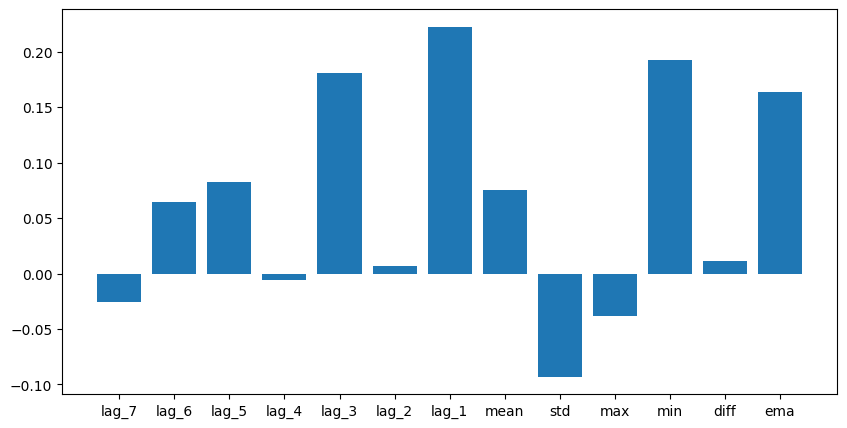

In [ ]:
plt.figure(figsize=(10, 5))
feature_names = [f"lag_{i}" for i in range(ws, 0, -1)] + ["mean", "std", "max", "min", "diff", "ema"]
plt.bar(feature_names, model.model.coef_)
plt.show()

In [35]:
from sklearn.neural_network import MLPRegressor
datasets = build_datasets(new_ts, ws)
evaluate_model(MLPRegressor(), datasets)

R^2 = 0.58804
RMSE = 0.00461
MAE = 0.00267
MAPE = 0.10085


In [24]:
class CBMRegressor(RegressorMixin, BaseEstimator):
    def __init__(self, ws, lr):
        super().__init__()
        self.model = CatBoostRegressor(verbose=False)
        self.ws = ws
        self.lr = lr
        self.ema_coef_ = np.array([1/3 * 2/3 ** i for i in range(self.ws)[::-1]])

    def get_features(self, X, emas):
        means = X.mean(axis=1)[:, None]
        stds = X.std(axis=1)[:, None]
        maxs = X.max(axis=1)[:, None]
        mins = X.min(axis=1)[:, None]
        mins = X.min(axis=1)[:, None]
        diffs = (X[:, -1] / X[:, -2])[:, None]
        emas = emas[:, None]
        return np.concatenate((X, means, stds, maxs, mins, diffs, emas), axis=1)

    def fit(self, X, y, eval_set):
        emas = (X @ self.ema_coef_)
        X = self.get_features(X, emas)
        diff = y # - emas
        if eval_set:
            eval_X, eval_y = eval_set
            eval_emas = (eval_X @ self.ema_coef_)
            eval_diff = eval_y # - eval_emas
            eval_X = self.get_features(eval_X, eval_emas)
            eval_set = (eval_X, eval_diff)
            self.model.fit(X, diff, eval_set=eval_set, early_stopping_rounds=50)
        else:
            self.model.fit(X, diff)

    def predict(self, X):
        emas = X @ self.ema_coef_
        X = self.get_features(X, emas)
        # return emas + self.lr * self.model.predict(X)
        return self.model.predict(X)

In [41]:
datasets = build_datasets(new_ts, ws)
model = CBMRegressor(ws, 1.)
m = evaluate_model(model, datasets, needs_eval=True)

R^2 = 0.62576
RMSE = 0.00435
MAE = 0.00252
MAPE = 0.09703


In [42]:
m

[0.6257640674438116,
 0.004350731051507757,
 0.0025164864616719013,
 0.09702802640788304]

In [43]:
class TSRegressor(RegressorMixin, BaseEstimator):
    def __init__(self, ws, lr):
        super().__init__()
        self.model = CatBoostRegressor(verbose=False)
        self.ws = ws
        self.lr = lr
        self.ema_coef_ = np.array([1/3 * 2/3 ** i for i in range(self.ws)[::-1]])

    def get_features(self, X, emas):
        means = X.mean(axis=1)[:, None]
        stds = X.std(axis=1)[:, None]
        maxs = X.max(axis=1)[:, None]
        mins = X.min(axis=1)[:, None]
        mins = X.min(axis=1)[:, None]
        diffs = (X[:, -1] / X[:, -2])[:, None]
        emas = emas[:, None]
        return np.concatenate((X, means, stds, maxs, mins, diffs, emas), axis=1)

    def fit(self, X, y, eval_set):
        emas = (X @ self.ema_coef_)
        X = self.get_features(X, emas)
        diff = y - emas
        if eval_set:
            eval_X, eval_y = eval_set
            eval_emas = (eval_X @ self.ema_coef_)
            eval_diff = eval_y - eval_emas
            eval_X = self.get_features(eval_X, eval_emas)
            eval_set = (eval_X, eval_diff)
            self.model.fit(X, diff, eval_set=eval_set, early_stopping_rounds=50)
        else:
            self.model.fit(X, diff)

    def predict(self, X):
        emas = X @ self.ema_coef_
        X = self.get_features(X, emas)
        return emas + self.lr * self.model.predict(X)

In [44]:
datasets = build_datasets(new_ts, ws)
model = TSRegressor(ws, 0.8)
m = evaluate_model(model, datasets, needs_eval=True)

R^2 = 0.62838
RMSE = 0.00434
MAE = 0.00245
MAPE = 0.09463


In [45]:
m

[0.6283763824838479,
 0.004335519546429603,
 0.002445904603667376,
 0.09462574723966466]

In [28]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
!pip install pmdarima
import pmdarima as pm

In [31]:
model = pm.arima.ARIMA(order=(2, 1, 2))
fit = model.fit(test_y)
preds = fit.fittedvalues()

In [32]:
print('ARIMA')
print(f'R2 = {r2_score(test_y, preds):.5f}')
print(f'RMSE = {mean_squared_error(test_y, preds, squared=False):.5f}')
print(f'MAE = {mean_absolute_error(test_y, preds):.5f}')
print(f'MAPE = {mean_absolute_percentage_error(test_y, preds):.5f}')

ARIMA
R2 = 0.55983
RMSE = 0.00477
MAE = 0.00279
MAPE = 0.10892


In [33]:
import scipy.stats as ss

KstestResult(statistic=0.12967045887447382, pvalue=0.0, statistic_location=0.0021977118029998625, statistic_sign=1)

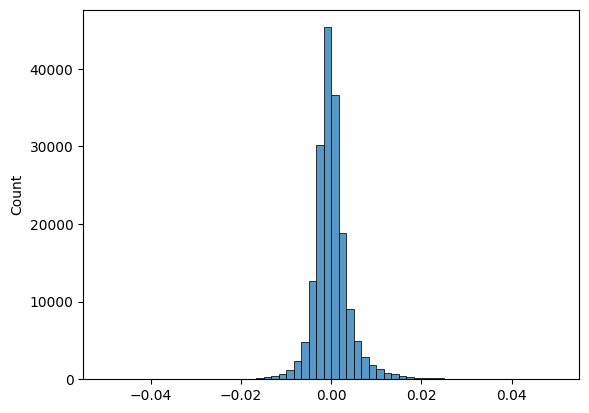

In [34]:
resid = fit.resid()
sns.histplot(resid.clip(-0.05, 0.05), bins=60)
ss.ks_1samp(resid, ss.norm(loc=resid.mean(), scale=resid.std()).cdf)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

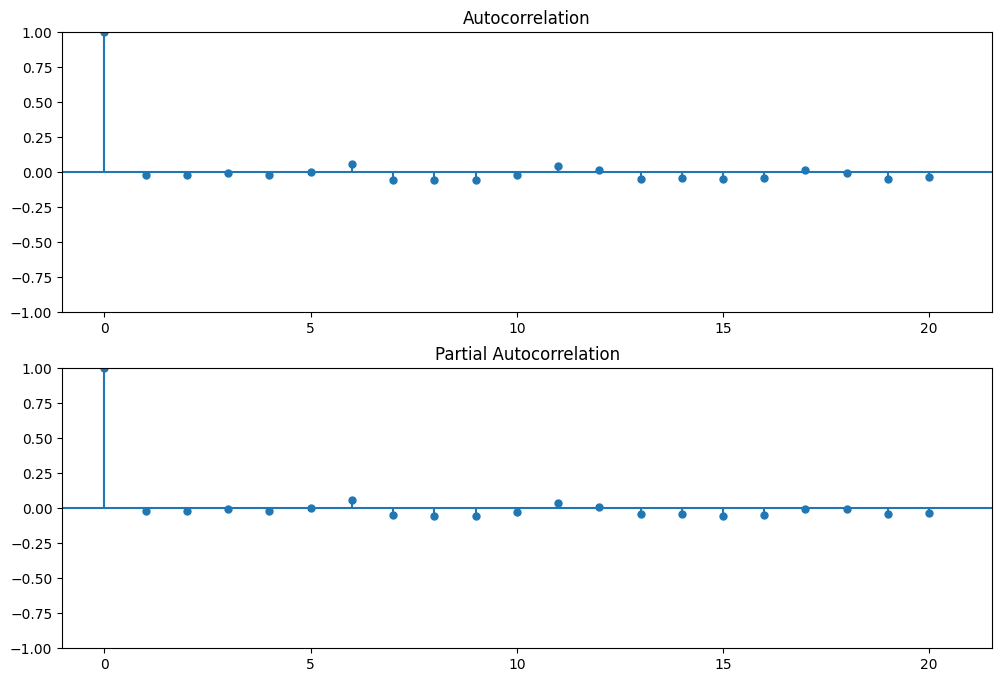

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(resid.values.squeeze(), lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(resid, lags=20, ax=ax2)